# 8. 비지도 학습
## 8.5 이미지 스타일 변이

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
#import copy

In [22]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [23]:
#cd/content/gdrive/My Drive/pytorch_dlbro

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 손실함수

In [25]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [26]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)  
    G = torch.mm(features, features.t())
    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [27]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## 모델 정의

In [28]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [29]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

## 모델 재정의

In [30]:
def get_style_model_and_losses(cnn, style_img, content_img):

    #cnn = copy.deepcopy(cnn)
    content_layers = ['conv_4'] # 피쳐맵을 추출하려는 컨텐츠 레이어
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'] # 관심있는 스타일 레이어들
    normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device) # 정규화를 위한 평균 정의
    normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device) # 정규화를 위한 표준편차 정의
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = [] # 컨텐츠 손실 함수 저장 리스트
    style_losses = [] # 스타일 손실 함수 저장 리스트

    model = nn.Sequential(normalization) # 입력값을 정규화한다.

    i = 0  
    for layer in cnn.children(): # 층 정보를 하나 씩 불러와 모델 구축
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'maxpool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers: # 원하는 컨텐츠 레이어에서 손실함수를 계산을 추가한다.
            target = model(content_img)
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers: # 원하는 스타일 레이어에서 손실함수를 계산을 추가한다.
            target_feature = model(style_img)
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1): # 모델을 뒤 부터 확인하여 가장 마지막 위치의 손실 함수를 확인한다.
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)] # 사용할 층까지만 잘라서 모델을 재정의

    return model, style_losses, content_losses

## 최적화 기법 및 학습 정의

In [31]:
def run_style_transfer(cnn, content_img, style_img, num_steps=300, style_weight=100000, content_weight=1):

    input_img = content_img.clone().detach().requires_grad_(True)
    model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)
    optimizer = optim.LBFGS([input_img])
    iteration = [0]
    while iteration[0] <= num_steps:
        def closure():  
            input_img.data.clamp_(0, 1) # 0이상 1이하의 값만 사용한다.
            optimizer.zero_grad()
            model(input_img) # 손실 함수들이 들어가 재정의 된 모델이다.
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss # 각 레이어들의 손실 MSE 함수를 불러와 더한다.
            for cl in content_losses:
                content_score += cl.loss # 각 레이어들의 손실 MSE 함수를 불러와 더한다.

            loss = style_weight*style_score + content_weight*content_score # 가중치를 결합한 최종 손실 함수 정의
            loss.backward()

            iteration[0] += 1
            if iteration[0] % 50 == 0:
                print('Iteration {}: Style Loss : {:4f} Content Loss: {:4f}'.format(
                    iteration[0], style_score.item(), content_score.item()))

            return style_score + content_score

        optimizer.step(closure)

    return input_img.data.clamp_(0, 1)

## 이미지 불러오기 및 모델 실행하기

In [32]:
def image_loader(img_path):
    loader = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
    image = Image.open(img_path).convert('RGB')
    image = loader(image).unsqueeze(0) # 4차원 텐서 변환
    return image.to(device)

style_img = image_loader("./data/imgA.jpg")
content_img = image_loader("./data/imgB.jpg")

In [33]:
output = run_style_transfer(cnn, content_img, style_img)
# torch.Size([128, 1, 28, 28]) 스택오버플로우
# 128 : mini-batch size(데이터 한 묶음당 들어있는 데이터쌍(x-y) 개수)
# 1 : channel size
# 28 : img size
# 28 : img size
# torch.Size([1, 128, 128, 129]) 현재 데이터

Iteration 50: Style Loss : 0.000141 Content Loss: 50.040894
Iteration 100: Style Loss : 0.000040 Content Loss: 38.341309
Iteration 150: Style Loss : 0.000026 Content Loss: 32.725464
Iteration 200: Style Loss : 0.000027 Content Loss: 29.791103
Iteration 250: Style Loss : 0.000019 Content Loss: 28.590845
Iteration 300: Style Loss : 0.000019 Content Loss: 27.873619


In [34]:
def imshow(image, title):
    unloader = transforms.ToPILImage()
    image = unloader(image.squeeze(0).cpu())
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

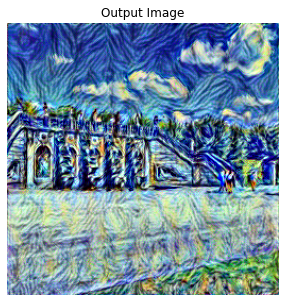

In [35]:
imshow(output, title='Output Image')

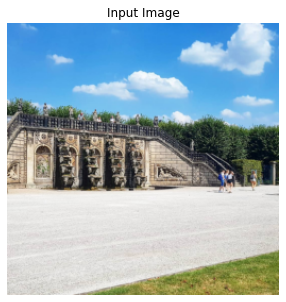

In [36]:
imshow(content_img, title='Input Image')

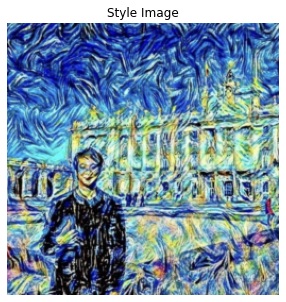

In [37]:
imshow(style_img, title='Style Image')